In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2025-03-09 13:38:55 +08:00)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

time: 3.86 s (started: 2025-03-09 13:42:04 +08:00)


In [71]:
import pandas as pd
import yfinance as yf

# Ambil data dari Yahoo Finance untuk masing-masing ticker
gold_futures = yf.download('GC=F', start='2005-01-01', end='2025-03-07')['Close']
usd_idr_data = yf.download('IDR=X', start='2005-01-01', end='2025-03-07')['Close']
# bca_data = yf.download('BBCA.JK', start='2005-01-01', end='2025-03-07')['Close']
visa_data = yf.download('V', start='2005-01-01', end='2025-03-07')['Close']
apple_data = yf.download('AAPL', start='2005-01-01', end='2025-03-07')['Close']
msft_data = yf.download('MSFT', start='2005-01-01', end='2025-03-07')['Close']

# Gabungkan data ke dalam satu DataFrame dengan outer join
data = pd.concat([gold_futures, usd_idr_data, visa_data, apple_data, msft_data], axis=1, join='outer')

# Beri nama kolom
data.columns = ['Gold_Futures_USD', 'USD_IDR',  'Visa_USD', 'Apple_USD', 'MSFT_USD']

# Forward fill untuk menangani nilai kosong (jika ada)
data.ffill(inplace=True)

# Konversi harga emas dari USD/ons ke Rupiah/gram
data['Gold_Futures_IDR_per_gram'] = (data['Gold_Futures_USD'] * data['USD_IDR']) / 31.1035

# Konversi semua saham AS ke Rupiah
data['Visa_IDR'] = data['Visa_USD'] * data['USD_IDR']
data['Apple_IDR'] = data['Apple_USD'] * data['USD_IDR']
data['MSFT_IDR'] = data['MSFT_USD'] * data['USD_IDR']

# Hapus kolom harga saham dalam USD dan harga emas dalam USD
data = data.drop(['Gold_Futures_USD', 'Visa_USD', 'Apple_USD', 'MSFT_USD','MSFT_IDR','USD_IDR'], axis=1)

# Tampilkan DataFrame
print(data.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

            Gold_Futures_IDR_per_gram  Visa_IDR    Apple_IDR
Date                                                        
2005-01-03              127942.211193       NaN  8839.935911
2005-01-04              127934.880878       NaN  8934.375235
2005-01-05              127255.140417       NaN  9004.667421
2005-01-06              125891.911343       NaN  9033.694623
2005-01-07              125103.671397       NaN  9679.052142
time: 375 ms (started: 2025-03-09 14:21:57 +08:00)


In [72]:
df = data.loc['2021-06-01':]
df

,Gold_Futures_IDR_per_gram,Visa_IDR,Apple_IDR
Date,,,
2021-06-01,8.716565e+05,3.140187e+06,1.735093e+06
2021-06-02,8.740089e+05,3.183064e+06,1.746473e+06
2021-06-03,8.597347e+05,3.170277e+06,1.729991e+06
2021-06-04,8.724912e+05,3.214001e+06,1.771448e+06
2021-06-07,8.713321e+05,3.214282e+06,1.762706e+06
...,...,...,...
2025-03-03,1.535258e+06,5.977990e+06,3.932732e+06
2025-03-04,1.538940e+06,5.794606e+06,3.881331e+06
2025-03-05,1.535187e+06,5.776546e+06,3.861186e+06


time: 16 ms (started: 2025-03-09 14:21:58 +08:00)


C:\Users\US3R\AppData\Local\Temp\ipykernel_18548\3119790036.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns = df.pct_change().fillna(method='ffill').dropna()



📌 Portofolio Risiko Minimum (MVP):
   Gold_Futures_IDR_per_gram: 66.22%
   Visa_IDR: 23.88%
   Apple_IDR: 9.90%
   Expected Return (Annual): 17.05%
   Risk (Standard Deviation, Annual): 14.13%


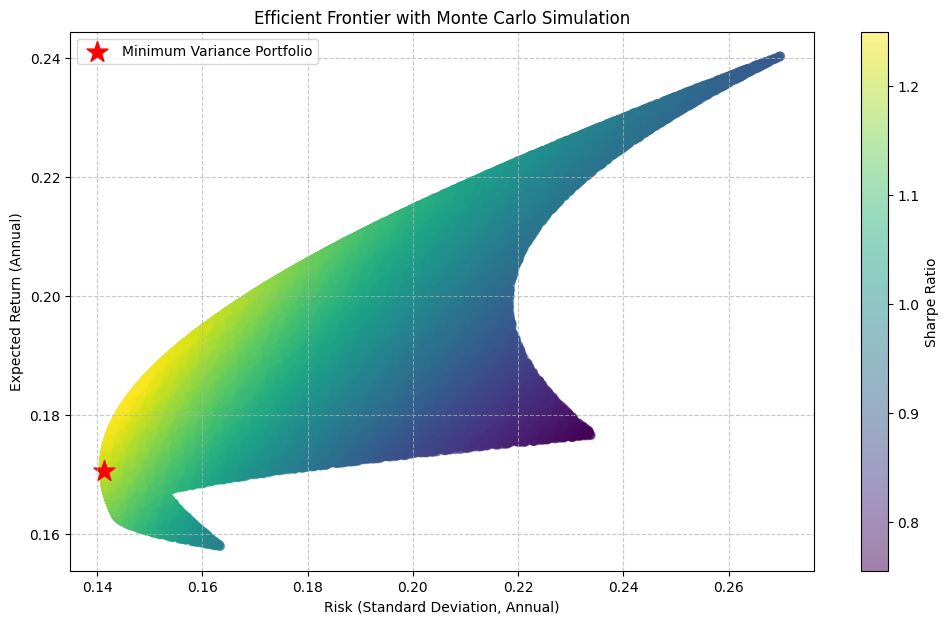

time: 24.4 s (started: 2025-03-09 14:21:58 +08:00)


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 🟢 1. Hitung return harian dengan handling NaN yang benar
returns = df.pct_change().fillna(method='ffill').dropna()

# 🟢 2. Hitung return ekspektasi dan matriks kovarians
expected_returns = returns.mean()
cov_matrix = returns.cov()

# 🟢 3. Fungsi untuk menghitung risiko portofolio (standard deviation)
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

# 🟢 4. Optimasi untuk menemukan Minimum Variance Portfolio (MVP)
num_assets = len(expected_returns)
init_guess = np.ones(num_assets) / num_assets  # Bobot awal (rata)
bounds = [(0, 1) for _ in range(num_assets)]  # Setiap aset antara 0% - 100%
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Total bobot harus 100%

# Optimasi dengan SLSQP untuk meminimalkan risiko
optimal_result = minimize(
    portfolio_volatility, init_guess, args=(cov_matrix,),
    method='SLSQP', bounds=bounds, constraints=constraints
)
optimal_weights = optimal_result.x

# 🟢 5. Hitung return dan risiko portofolio MVP
min_var_return = np.sum(optimal_weights * expected_returns) * 252  # Skala tahunan
min_var_risk = portfolio_volatility(optimal_weights, cov_matrix) * np.sqrt(252)  # Skala tahunan

# 🟢 6. Cetak hasil MVP
print("\n📌 Portofolio Risiko Minimum (MVP):")
for asset, weight in zip(df.columns, optimal_weights):
    print(f"   {asset}: {weight:.2%}")
print(f"   Expected Return (Annual): {min_var_return:.2%}")
print(f"   Risk (Standard Deviation, Annual): {min_var_risk:.2%}")

# 🟢 7. Monte Carlo Simulation untuk Efficient Frontier
num_portfolios = 100000
risk_list = []
return_list = []
weights_list = []

for _ in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]
    port_return = np.sum(weights * expected_returns) * 252  # Skala tahunan
    port_risk = portfolio_volatility(weights, cov_matrix) * np.sqrt(252)  # Skala tahunan

    return_list.append(port_return)
    risk_list.append(port_risk)
    weights_list.append(weights)

# 🟢 8. Plot Efficient Frontier dengan Monte Carlo Simulation
plt.figure(figsize=(12, 7))
plt.scatter(risk_list, return_list, c=np.array(return_list)/np.array(risk_list), cmap='viridis', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(min_var_risk, min_var_return, color='red', marker='*', s=250, label='Minimum Variance Portfolio')
plt.xlabel('Risk (Standard Deviation, Annual)')
plt.ylabel('Expected Return (Annual)')
plt.title('Efficient Frontier with Monte Carlo Simulation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Sharpe Ratio

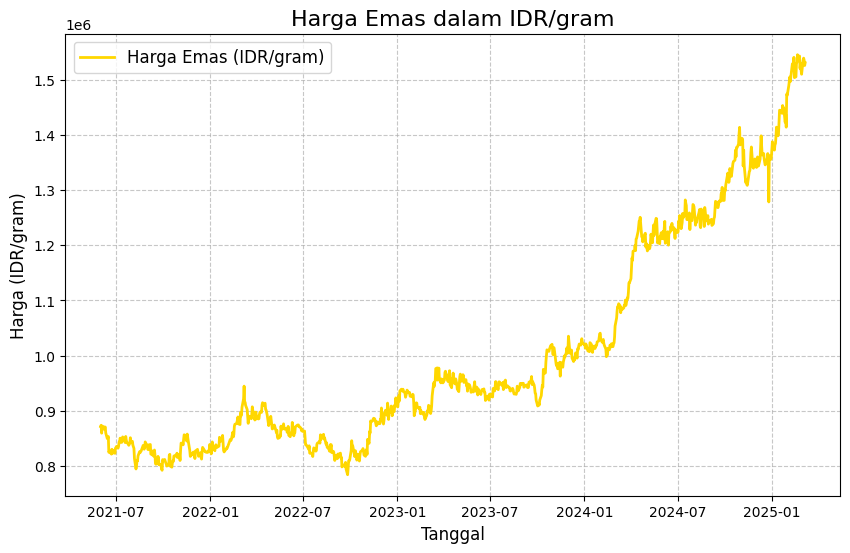

time: 171 ms (started: 2025-03-09 14:22:22 +08:00)


In [74]:
import matplotlib.pyplot as plt

# Asumsikan `df` adalah dfFrame yang sudah ada
plt.figure(figsize=(10, 6))  # Atur ukuran plot
plt.plot(df.index, df['Gold_Futures_IDR_per_gram'], label='Harga Emas (IDR/gram)', color='gold', linewidth=2)

# Atur judul dan label
plt.title('Harga Emas dalam IDR/gram', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga (IDR/gram)', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Tambahkan grid

# Tampilkan plot
plt.show()

In [75]:
df

,Gold_Futures_IDR_per_gram,Visa_IDR,Apple_IDR
Date,,,
2021-06-01,8.716565e+05,3.140187e+06,1.735093e+06
2021-06-02,8.740089e+05,3.183064e+06,1.746473e+06
2021-06-03,8.597347e+05,3.170277e+06,1.729991e+06
2021-06-04,8.724912e+05,3.214001e+06,1.771448e+06
2021-06-07,8.713321e+05,3.214282e+06,1.762706e+06
...,...,...,...
2025-03-03,1.535258e+06,5.977990e+06,3.932732e+06
2025-03-04,1.538940e+06,5.794606e+06,3.881331e+06
2025-03-05,1.535187e+06,5.776546e+06,3.861186e+06


time: 16 ms (started: 2025-03-09 14:22:22 +08:00)


C:\Users\US3R\AppData\Local\Temp\ipykernel_18548\526494368.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns = df.pct_change().fillna(method='ffill').dropna()
Running Monte Carlo Simulation: 100%|██████████| 1000000/1000000 [03:31<00:00, 4737.00it/s]


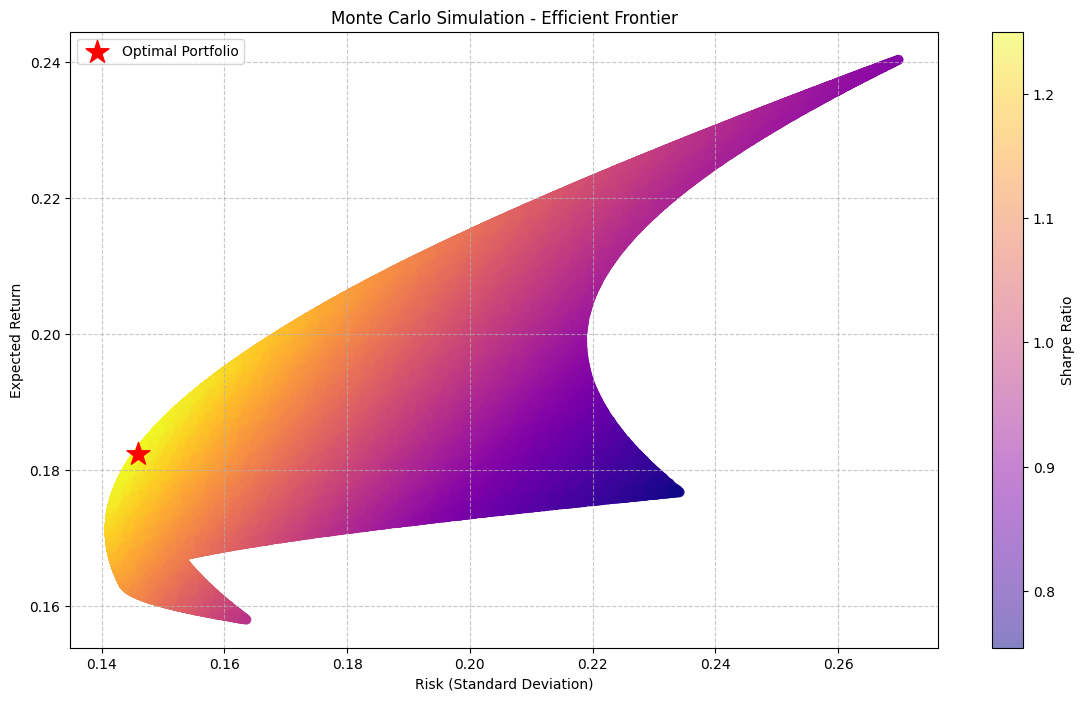


📌 Portofolio Optimal (Maksimum Sharpe Ratio):
   Gold_Futures_IDR_per_gram: 59.02%
   Visa_IDR: 14.72%
   Apple_IDR: 26.26%
   Expected Return: 18.23%
   Risk (Standard Deviation): 14.59%
   Sharpe Ratio: 1.25
   Annual Expected Return: 18.23%
time: 3min 50s (started: 2025-03-09 14:22:23 +08:00)


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm  # Import tqdm untuk progress bar

# Hitung return harian dengan menangani NaN lebih baik
returns = df.pct_change().fillna(method='ffill').dropna()

# Hitung return ekspektasi tahunan dan matriks kovarians
expected_returns = returns.mean()
cov_matrix = returns.cov()

# Monte Carlo Simulation
num_assets = len(expected_returns)
num_portfolios = 1000000  # Jumlah simulasi Monte Carlo

results = np.zeros((4, num_portfolios))  # [Return, Risiko, Sharpe Ratio, Bobot]
weights_list = []

# Gunakan tqdm untuk progress bar
for i in tqdm(range(num_portfolios), desc="Running Monte Carlo Simulation"):
    weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]  # Bobot portofolio
    weights_list.append(weights)

    port_return = np.sum(weights * expected_returns) * 252  # Skala ke tahunan
    port_risk = np.sqrt(weights.T @ cov_matrix @ weights * 252)  # Skala ke tahunan
    sharpe_ratio = port_return / port_risk if port_risk != 0 else 0  # Hindari div/0

    results[0, i] = port_return
    results[1, i] = port_risk
    results[2, i] = sharpe_ratio

# Mencari portofolio optimal (Maksimum Sharpe Ratio)
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_list[max_sharpe_idx]

# Hitung expected return tahunan untuk portofolio optimal
expected_return_optimal = np.sum(optimal_weights * expected_returns) * 252

# Visualisasi Monte Carlo Simulation
plt.figure(figsize=(14, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='plasma', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], color='red', marker='*', s=300, label='Optimal Portfolio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Monte Carlo Simulation - Efficient Frontier')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Output bobot optimal
print("\n📌 Portofolio Optimal (Maksimum Sharpe Ratio):")
for asset, weight in zip(['Gold_Futures_IDR_per_gram', 'Visa_IDR', 'Apple_IDR'], optimal_weights):
    print(f"   {asset}: {weight:.2%}")
print(f"   Expected Return: {results[0, max_sharpe_idx]:.2%}")
print(f"   Risk (Standard Deviation): {results[1, max_sharpe_idx]:.2%}")
print(f"   Sharpe Ratio: {results[2, max_sharpe_idx]:.2f}")
print(f"   Annual Expected Return: {expected_return_optimal:.2%}")


In [77]:
optimal_weights

array([0.59020942, 0.14716617, 0.26262442])

time: 0 ns (started: 2025-03-09 14:26:13 +08:00)


In [78]:
optimal_weights


# weight setahun terakhir

array([0.59020942, 0.14716617, 0.26262442])

time: 0 ns (started: 2025-03-09 14:26:13 +08:00)


In [79]:
custom_weight = np.array([0.75, 0.20, 0.05])

time: 0 ns (started: 2025-03-09 14:26:13 +08:00)


# Backtesting porto

In [80]:
data

,Gold_Futures_IDR_per_gram,Visa_IDR,Apple_IDR
Date,,,
2005-01-03,1.279422e+05,NaN,8.839936e+03
2005-01-04,1.279349e+05,NaN,8.934375e+03
2005-01-05,1.272551e+05,NaN,9.004667e+03
2005-01-06,1.258919e+05,NaN,9.033695e+03
2005-01-07,1.251037e+05,NaN,9.679052e+03
...,...,...,...
2025-03-03,1.535258e+06,5.977990e+06,3.932732e+06
2025-03-04,1.538940e+06,5.794606e+06,3.881331e+06
2025-03-05,1.535187e+06,5.776546e+06,3.861186e+06


time: 16 ms (started: 2025-03-09 14:26:14 +08:00)


[*********************100%***********************]  1 of 1 completed
C:\Users\US3R\AppData\Local\Temp\ipykernel_18548\149331209.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ihsg = ihsg.reindex(data.index).fillna(method='ffill')  # Sesuaikan dengan indeks `data`


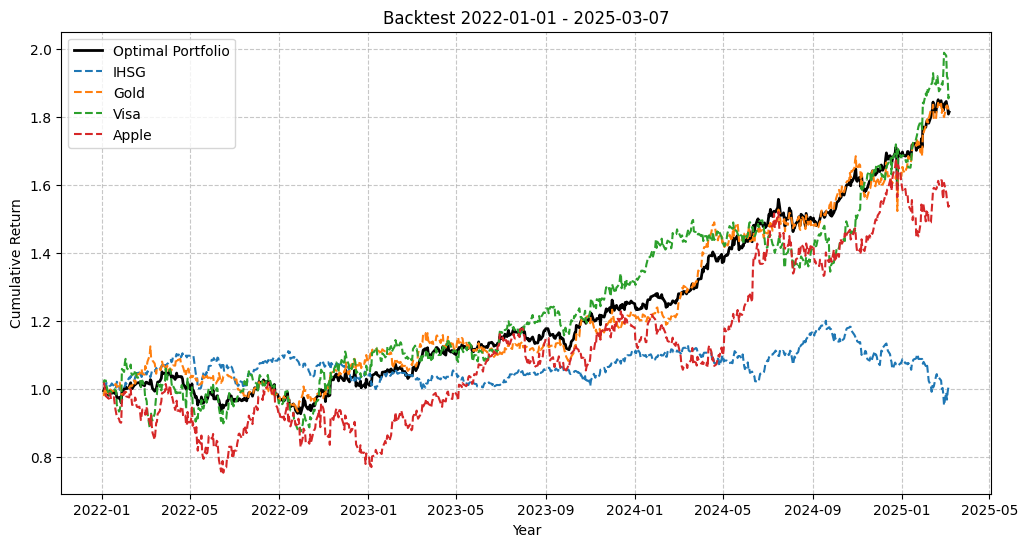


📌 Hasil Backtest (2022-01-01 - 2025-03-07):
   CAGR: 19.99%
   Sharpe Ratio: 1.08
   Max Drawdown: -11.90%


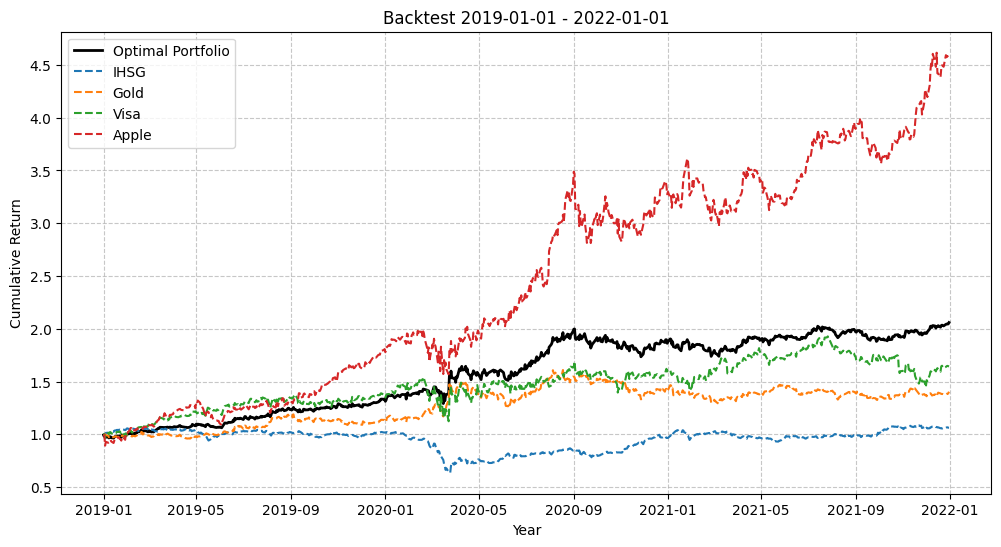


📌 Hasil Backtest (2019-01-01 - 2022-01-01):
   CAGR: 26.39%
   Sharpe Ratio: 1.05
   Max Drawdown: -13.21%


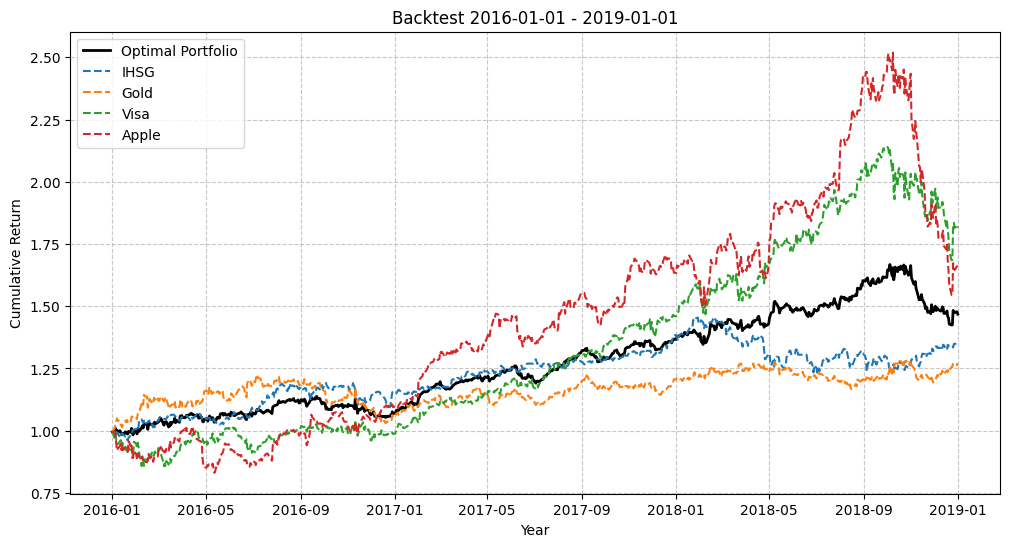


📌 Hasil Backtest (2016-01-01 - 2019-01-01):
   CAGR: 13.34%
   Sharpe Ratio: 0.81
   Max Drawdown: -14.57%


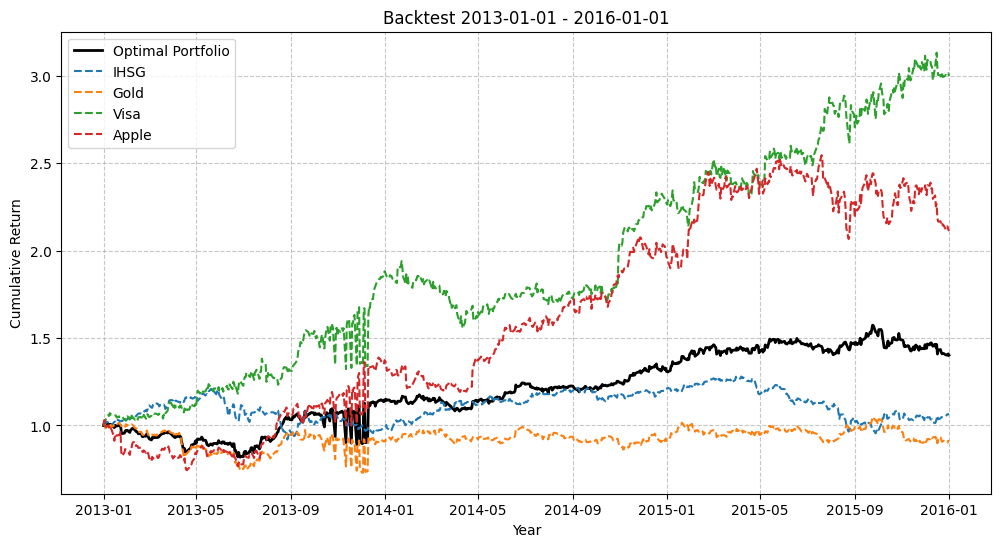


📌 Hasil Backtest (2013-01-01 - 2016-01-01):
   CAGR: 11.48%
   Sharpe Ratio: 0.39
   Max Drawdown: -20.10%


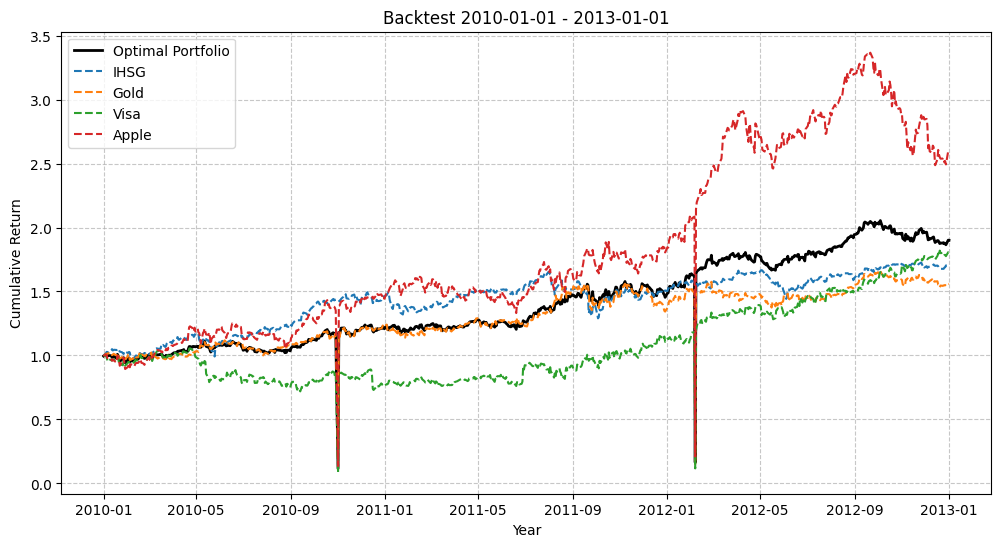


📌 Hasil Backtest (2010-01-01 - 2013-01-01):
   CAGR: 23.13%
   Sharpe Ratio: 0.75
   Max Drawdown: -90.30%
time: 1.06 s (started: 2025-03-09 14:26:14 +08:00)


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 🟢 1. AMBIL DATA HISTORIS 10 TAHUN TERAKHIR
ihsg = yf.download('^JKSE', start='2005-01-01', end='2025-03-07')['Close']
ihsg = ihsg.reindex(data.index).fillna(method='ffill')  # Sesuaikan dengan indeks `data`

new_data = data.copy()
new_data['IHSG'] = ihsg
new_data = new_data.loc['2005-06-01':]  # Hanya ambil 3 tahun terakhir

returns = new_data.pct_change().dropna()

# 🟢 2. BACKTEST PORTOFOLIO
def backtest_portfolio(weights, returns, start_date, end_date):
    selected_returns = returns.loc[start_date:end_date]
    
    # Cek apakah data tersedia
    if selected_returns.empty:
        print(f"\n⚠️  Skipping {start_date} - {end_date}: No data available!")
        return
    
    portfolio_returns = (selected_returns[['Gold_Futures_IDR_per_gram','Visa_IDR','Apple_IDR']] @ weights).to_frame("Portfolio Return")
    cumulative_returns = (1 + portfolio_returns).cumprod()
    
    benchmark_returns = selected_returns[['IHSG', 'Gold_Futures_IDR_per_gram','Visa_IDR','Apple_IDR']]
    benchmark_cumulative = (1 + benchmark_returns).cumprod()
    
    # PLOT
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Optimal Portfolio', linewidth=2, color='black')
    plt.plot(benchmark_cumulative, linestyle='dashed')
    plt.legend(['Optimal Portfolio', 'IHSG', 'Gold', 'Visa', 'Apple'])
    plt.xlabel('Year')
    plt.ylabel('Cumulative Return')
    plt.title(f'Backtest {start_date} - {end_date}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Kinerja Portofolio
    risk_free_rate = 0.03 / 252
    excess_returns = portfolio_returns - risk_free_rate
    sharpe_ratio = excess_returns.mean() / portfolio_returns.std() * np.sqrt(252)
    
    # Cek apakah cumulative_returns punya cukup data sebelum mengambil iloc[-1] dan iloc[0]
    if len(cumulative_returns) > 1:
        cagr = (cumulative_returns.iloc[-1] / cumulative_returns.iloc[0])**(1/(len(selected_returns)/252)) - 1
        max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
        
        print(f"\n📌 Hasil Backtest ({start_date} - {end_date}):")
        print(f"   CAGR: {cagr.iloc[0]:.2%}")
        print(f"   Sharpe Ratio: {sharpe_ratio.iloc[0]:.2f}")
        print(f"   Max Drawdown: {max_drawdown.iloc[0]:.2%}")
    else:
        print(f"\n⚠️  Not enough data for {start_date} - {end_date} to calculate CAGR/Drawdown!")


test_periods = [
    ('2022-01-01', '2025-03-07'),
    ('2019-01-01', '2022-01-01'),
    ('2016-01-01', '2019-01-01'),
    ('2013-01-01', '2016-01-01'),
    ('2010-01-01', '2013-01-01')
]


for start, end in test_periods:
    backtest_portfolio(optimal_weights, returns, start, end)

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rolling_backtest(returns, weights, start_year, end_year, window=3):
    results = []
    for start in range(start_year, end_year - window + 1):  # Rolling setiap tahun
        start_date = f"{start}-01-01"
        end_date = f"{start + window}-01-01"
        
        # Pilih periode sesuai window
        selected_returns = returns.loc[start_date:end_date]
        if selected_returns.empty:
            continue
        
        # Hitung metrik backtest
        portfolio_returns = (selected_returns[['Gold_Futures_IDR_per_gram','Visa_IDR','Apple_IDR']] @ weights)
        cumulative_returns = (1 + portfolio_returns).cumprod()
        risk_free_rate = 0.03 / 252  # Asumsi 3% per tahun
        excess_returns = portfolio_returns - risk_free_rate
        sharpe_ratio = excess_returns.mean() / portfolio_returns.std() * np.sqrt(252)
        cagr = (cumulative_returns.iloc[-1] / cumulative_returns.iloc[0])**(1/window) - 1
        max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
        
        results.append({
            "Period": f"{start}-{start + window}",
            "CAGR": cagr,
            "Sharpe Ratio": sharpe_ratio,
            "Max Drawdown": max_drawdown
        })
    
    return pd.DataFrame(results)

# Jalankan rolling backtest dari 2010 hingga 2025
df_results = rolling_backtest(returns, optimal_weights, 2010, 2025, window=3)
print(df_results)


       Period      CAGR  Sharpe Ratio  Max Drawdown
0   2010-2013  0.240508      0.745183     -0.902950
1   2011-2014  0.207228      0.554287     -0.900104
2   2012-2015  0.186513      0.549751     -0.900104
3   2013-2016  0.119326      0.392911     -0.201036
4   2014-2017  0.096292      0.475968     -0.119673
5   2015-2018  0.137949      0.783120     -0.119673
6   2016-2019  0.138488      0.805776     -0.145663
7   2017-2020  0.218738      1.371019     -0.146051
8   2018-2021  0.265816      1.020596     -0.146051
9   2019-2022  0.274888      1.046646     -0.132051
10  2020-2023  0.169425      0.627450     -0.132051
11  2021-2024  0.111466      0.577080     -0.118981
12  2022-2025  0.191192      0.987374     -0.118981
time: 31 ms (started: 2025-03-09 14:26:15 +08:00)


# Uji Stres

In [83]:
data

,Gold_Futures_IDR_per_gram,Visa_IDR,Apple_IDR
Date,,,
2005-01-03,1.279422e+05,NaN,8.839936e+03
2005-01-04,1.279349e+05,NaN,8.934375e+03
2005-01-05,1.272551e+05,NaN,9.004667e+03
2005-01-06,1.258919e+05,NaN,9.033695e+03
2005-01-07,1.251037e+05,NaN,9.679052e+03
...,...,...,...
2025-03-03,1.535258e+06,5.977990e+06,3.932732e+06
2025-03-04,1.538940e+06,5.794606e+06,3.881331e+06
2025-03-05,1.535187e+06,5.776546e+06,3.861186e+06


time: 16 ms (started: 2025-03-09 14:26:15 +08:00)


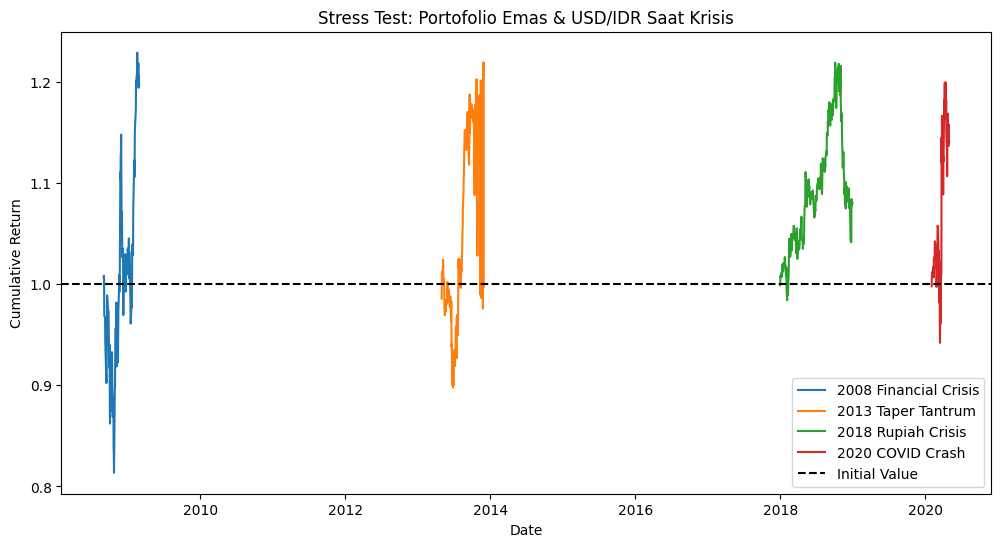

2008 Financial Crisis: 19.72%
2013 Taper Tantrum: -0.30%
2018 Rupiah Crisis: 8.02%
2020 COVID Crash: 14.12%
time: 532 ms (started: 2025-03-09 14:26:15 +08:00)


In [84]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# # Ambil data dari Yahoo Finance (GLD = emas, IDR=X = kurs USD/IDR)
# assets = ['GLD', 'IDR=X']
# data = yf.download(assets, start='2000-01-01', end='2025-03-05')['Close']

# Hitung return harian
returns = data.pct_change().dropna()

# Tentukan bobot portofolio berdasarkan hasil optimasi sebelumnya
weights = np.array([optimal_weights[0], optimal_weights[1],optimal_weights[2]])  # Bobot dari perhitungan sebelumnya

# Hitung return portofolio
portfolio_returns = returns.dot(weights)

# Periode krisis besar
crisis_periods = {
    "2008 Financial Crisis": ('2008-09-01', '2009-03-01'),
    "2013 Taper Tantrum": ('2013-05-01', '2013-12-01'),
    "2018 Rupiah Crisis": ('2018-01-01', '2018-12-31'),
    "2020 COVID Crash": ('2020-02-01', '2020-05-01')
}

# Visualisasi performa portofolio saat krisis
plt.figure(figsize=(12, 6))

for crisis, (start, end) in crisis_periods.items():
    crisis_data = portfolio_returns.loc[start:end]
    plt.plot(crisis_data.index, (1 + crisis_data).cumprod(), label=crisis)

plt.axhline(y=1, color='black', linestyle='--', label="Initial Value")
plt.legend()
plt.title("Stress Test: Portofolio Emas & USD/IDR Saat Krisis")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.show()

# Menampilkan return selama krisis
for crisis, (start, end) in crisis_periods.items():
    crisis_return = (1 + portfolio_returns.loc[start:end]).cumprod().iloc[-1] - 1
    print(f"{crisis}: {crisis_return:.2%}")


# Olah harga emas

In [ ]:
import pandas as pd

df = pd.read_excel('/content/the-gold-token-20250307111622912.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: '/content/the-gold-token-20250307111622912.xlsx'

time: 63 ms (started: 2025-03-09 14:26:15 +08:00)


In [ ]:
df

In [ ]:
from datetime import datetime


# Konversi timestamp (dalam milidetik) ke format datetime
df["timeOpen"] = pd.to_datetime(df["timeOpen"], unit="ms")
df["timeClose"] = pd.to_datetime(df["timeClose"], unit="ms")

# Cetak hasil
print(df)

In [ ]:
df.head(5)

# Switching Porto

# New section

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Ambil return harian dari data
returns = data.pct_change().dropna()

# Fit Markov Switching Model (2 states: Bull & Bear)
mod = MarkovRegression(returns['Gold'], k_regimes=2, trend='c', switching_variance=True)
res = mod.fit()

# Probabilitas pasar dalam kondisi Bull atau Bear
regime_probs = res.smoothed_marginal_probabilities

# Plot probabilitas
regime_probs.plot(title="Probabilitas Rezim Pasar")


In [ ]:
# Jika probabilitas Bear Market > 60%, pindahkan lebih banyak ke safe-haven
threshold = 0.6
crisis_mode = regime_probs[1] > threshold  # True jika pasar masuk Bear Market

# Atur bobot portofolio berdasarkan rezim
portfolio_alloc = pd.DataFrame(index=returns.index, columns=returns.columns)

for date in returns.index:
    if crisis_mode[date]:
        portfolio_alloc.loc[date] = [0.8, 0.2, 0.0]  # Emas 80%, USD 20%, Saham 0%
    else:
        portfolio_alloc.loc[date] = [0.4, 0.1, 0.5]  # Emas 40%, USD 10%, Saham 50%

# Visualisasi perubahan alokasi portofolio
portfolio_alloc.plot(title="Dynamic Portfolio Allocation")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Contoh Data Probabilitas Bear Market (Misalnya dari Markov Switching Model)
dates = pd.date_range(start="2005-01-01", periods=300, freq="M")
prob_bear_market = np.random.uniform(0, 1, len(dates))  # Probabilitas Acak (Untuk Ilustrasi)
gold_prices = np.cumsum(np.random.randn(len(dates))) + 100  # Harga Emas Sintetis

# Membuat DataFrame
data = pd.DataFrame({
    "Date": dates,
    "Prob_Bear": prob_bear_market,
    "Gold_Price": gold_prices
})
data.set_index("Date", inplace=True)

# Membuat Grafik
fig, ax1 = plt.subplots(figsize=(14, 6))  # Perbesar Ukuran Grafik

# Plot Harga Emas
ax1.plot(data.index, data["Gold_Price"], color="gold", linewidth=2, label="Gold Price (USD)")
ax1.set_ylabel("Gold Price (USD)", color="gold", fontsize=14)
ax1.tick_params(axis="y", labelcolor="gold")
ax1.set_title("Gold Price vs Bear Market Probability", fontsize=16)

# Plot Probabilitas Bear Market
ax2 = ax1.twinx()
ax2.plot(data.index, data["Prob_Bear"], color="red", linestyle="dashed", linewidth=2, label="Bear Market Probability")
ax2.fill_between(data.index, data["Prob_Bear"], alpha=0.3, color="red")  # Area Shading
ax2.set_ylabel("Bear Market Probability", color="red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red")

# Tambahkan Grid & Legenda
ax1.grid(True, linestyle="--", alpha=0.6)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), fontsize=12)

# Tampilkan Grafik
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gunakan data asli jika ada, misalnya data probabilitas bear dari model Markov Switching
historical_prob_bear = data["Prob_Bear"]

# Simulasi 12 bulan ke depan berdasarkan distribusi historis
future_dates = pd.date_range(start=data.index[-1], periods=12, freq="M")
simulated_prob_bear = np.random.choice(historical_prob_bear, size=12, replace=True)

# Simulasi Harga Emas (Monte Carlo dengan distribusi historis)
historical_gold_returns = data["Gold_Price"].pct_change().dropna()
simulated_gold_prices = [data["Gold_Price"].iloc[-1]]

for _ in range(12):
    simulated_gold_prices.append(simulated_gold_prices[-1] * (1 + np.random.choice(historical_gold_returns)))

# Buat DataFrame untuk Simulasi Masa Depan
future_data = pd.DataFrame({
    "Date": future_dates,
    "Prob_Bear": simulated_prob_bear,
    "Gold_Price": simulated_gold_prices[1:]  # Hapus harga awal agar panjangnya cocok
})
future_data.set_index("Date", inplace=True)

# Gabungkan dengan Data Historis
full_data = pd.concat([data, future_data])

# Plot Hasil Simulasi
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Harga Emas
ax1.plot(full_data.index, full_data["Gold_Price"], color="gold", linewidth=2, label="Gold Price (USD)")
ax1.set_ylabel("Gold Price (USD)", color="gold", fontsize=14)
ax1.tick_params(axis="y", labelcolor="gold")
ax1.set_title("Gold Price vs Bear Market Probability (Historical + Future Simulation)", fontsize=16)

# Plot Probabilitas Bear Market
ax2 = ax1.twinx()
ax2.plot(full_data.index, full_data["Prob_Bear"], color="red", linestyle="dashed", linewidth=2, label="Bear Market Probability")
ax2.fill_between(full_data.index, full_data["Prob_Bear"], alpha=0.3, color="red")
ax2.set_ylabel("Bear Market Probability", color="red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red")

# Tandai Bagian Simulasi
plt.axvline(x=future_data.index[0], color="blue", linestyle="--", linewidth=2, label="Start of Simulation")

# Tambahkan Grid & Legenda
ax1.grid(True, linestyle="--", alpha=0.6)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), fontsize=12)

# Tampilkan Grafik
plt.show()
